In [1]:
%load_ext autoreload
%autoreload 2
import os
import typing as T
import pickle as pkl
import matplotlib.pyplot as plt
import sys
import cv2
import yaml
import requests
import torch
import torch.nn as nn
import numpy as np
from xarray import DataArray
from tqdm.auto import tqdm
import io
from PIL import Image
from bioimageio_chatbot.image_processor import *


/Users/gkreder/opt/miniconda3/envs/novel-designer/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Debugging resize

bcyx (1, 3, 512, 512)
(1, 224, 224, 3)


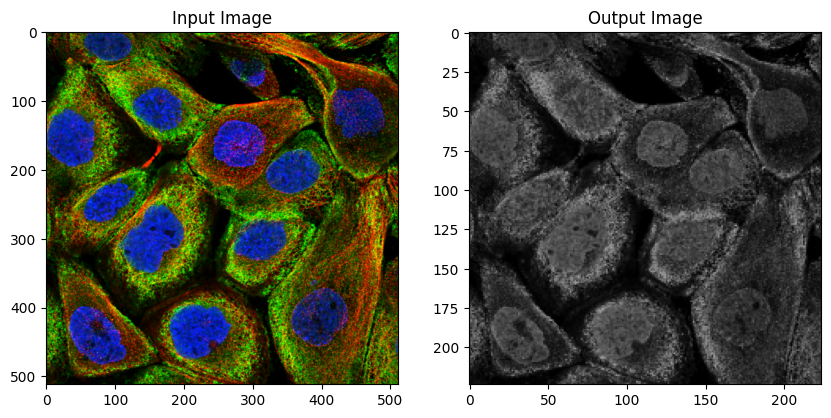

In [196]:
image_processor = ImageProcessor()
db_path = "../tmp/image_db_old/"
# input_image_path, input_axes = get_db_inputs(db_path, 'amiable-crocodile')
input_image_path, input_axes = get_db_inputs(db_path, 'loyal-parrot')
# input_image_path, input_axes = get_db_inputs(db_path, 'affable-shark')
# input_image_path, input_axes = get_db_inputs(db_path, 'straightforward-crocodile')
input_image = np.load(input_image_path)
output_image = image_processor.resize_image(input_image, input_axes, grayscale=True)
print(input_axes, input_image.shape)
print(output_image.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# axes[0].imshow(input_image[0,0,:,:])
axes[0].imshow(input_image.transpose(2,3,1,0)[:,:,:3,0], cmap = 'gray')
axes[0].set_title('Input Image')
# axes[0].axis('off')  # Turn off axis
axes[1].imshow(output_image[0,:,:,:])
axes[1].set_title('Output Image')
# axes[1].axis('off')  # Turn off axis
plt.show()
# plt.imshow(output_image[0,0,:,:])

# Testing embeddings on each image

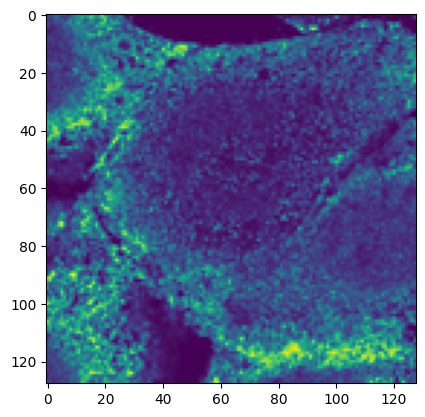

In [153]:
# test_image = input_image.transose()
plt.imshow(input_image[0,3,:,:])

# Test Embedding on every input image

In [436]:
import yaml
db_path = "../tmp/image_db"

db_path_old = "../tmp/image_db_old/"
rdf_dir_old = os.path.join(db_path_old, 'rdf_sources')
image_dir_old = os.path.join(db_path_old, 'input_images')
out_dir_grayscale = "../tmp/out_images_grayscale"
out_dir_color = "../tmp/out_images_color"
out_dir_all = "../tmp/out_images_all"
for d in [out_dir_grayscale, out_dir_color, out_dir_all]:
    os.makedirs(d, exist_ok=True)
image_processor = ImageProcessor()
check_model = None
for i_fname, fname in enumerate(tqdm(os.listdir(rdf_dir_old))):
    if not fname.endswith('.yaml'):
        continue
    model_name = fname.replace('.yaml', '')
    if check_model and model_name != check_model:
        continue
    rdf_dict = yaml.safe_load(open(os.path.join(rdf_dir_old, fname), 'r').read())
    input_image_path = os.path.join(image_dir_old, f"{model_name}.npy")
    input_image = np.load(input_image_path)
    input_axes = rdf_dict['inputs'][0]['axes'].lower()
    mislabeled_axes = {'impartial-shark' : 'yx'} # impartial shark has mislabeled axes
    if model_name in mislabeled_axes:
        input_axes = mislabeled_axes[model_name]
    
    res = search_torch_db(image_processor, input_image_path, input_axes, db_path, verbose = False)
    
    
    torch_image_grayscale = image_processor.get_torch_image(input_image_path, input_axes, grayscale=True)
    torch_image_color = image_processor.get_torch_image(input_image_path, input_axes, grayscale=False)
    embedded_image_grayscale = image_processor.embed_image(torch_image_grayscale.numpy(), "bcyx")
    embedded_image_color = image_processor.embed_image(torch_image_color.numpy(), "bcyx")
    fig, axes = plt.subplots(1, 5, figsize=(15, 3.2))
    standard_format = "byxcz"
    input_image_standardized = image_processor.standardize_image(input_image, input_axes, standard_format='yxc')
    output_image_grayscale = image_processor.standardize_image(torch_image_grayscale.numpy(), input_format = "bcyx", standard_format="yxc")
    # output_image_grayscale = cv2.normalize(output_image_grayscale, None, 0, 255, cv2.NORM_MINMAX)
    output_image_color = image_processor.standardize_image(torch_image_color.numpy(), input_format = "bcyx", standard_format="yxc")
    # output_image_color = cv2.normalize(output_image_color, None, 0, 255, cv2.NORM_MINMAX)
    axes[0].imshow(input_image_standardized)
    axes[0].set_title('Input Image')
    axes[1].imshow(output_image_grayscale.astype("int"))
    axes[1].set_title('Input (Grayscale)')
    axes[2].imshow(output_image_color.astype("int"))
    axes[2].set_title('Input (RGB)')

    axes[3].barh([len(res) - i for i in range(len(res))], [x[-1] for x in res])

    # Add text labels on each bar
    best_hit = res[0][-2]['config']['bioimageio']['nickname']
    best_score = res[0][-1]
    for i, hit in enumerate(res):
        value = hit[-1]
        hit_name = hit[-2]['config']['bioimageio']['nickname']
        # axes[3].text(i, value, f"{value:.4f}", ha='center', va='bottom')
        # axes[3].set_xlabel("Rank")
        # axes[3].set_ylabel('Similarity')
        axes[3].set_title(f"Best sim: {best_score:.3f}")

        # Label with the hit name, rotated vertically
        axes[3].text(value / 2, len(res) - i, hit_name, ha='center', va='center', rotation='horizontal', color = 'white', size = 6)
    axes[3].set_yticks([i+1 for i in range(len(res))])
    # axes[3].set_yticklabels([''] + [str(len(res) - i) for i in range(len(res))] + [''])
    axes[3].set_yticklabels([str(len(res) - i) for i in range(len(res))])

    pos_axes2 = axes[2].get_position()
    pos_axes3 = axes[3].get_position()
    new_width = pos_axes2.x1 - pos_axes2.x0
    new_height = pos_axes2.y1 - pos_axes2.y0
    height_diff = (pos_axes3.y1 - pos_axes3.y0) - new_height
    new_y0 = pos_axes3.y0 + ( height_diff / 2)
    # axes[3].set_position([pos_axes3.x0, pos_axes3.y0, new_width, new_height])
    axes[3].set_position([pos_axes3.x0, new_y0, new_width, new_height])

    best_hit_image_path, best_hit_axes = get_db_inputs(db_path, best_hit)
    if best_hit in mislabeled_axes:
        best_hit_axes = mislabeled_axes[best_hit]
    best_hit_image_standardized = image_processor.standardize_image(np.load(best_hit_image_path), input_format = best_hit_axes, standard_format="yxc")
    axes[4].imshow(best_hit_image_standardized)
    axes[4].set_title(f"{best_hit}")
    

    fig.suptitle(f"{model_name}")
    out_fig_name = os.path.join(out_dir_all, f"{model_name}.svg")
    plt.savefig(out_fig_name, bbox_inches = "tight")
    plt.close()
    if model_name == check_model:
        sys.exit()



KeyboardInterrupt: 

In [445]:
import yaml
db_path = "../tmp/image_db"

db_path_old = "../tmp/image_db_old/"
rdf_dir_old = os.path.join(db_path_old, 'rdf_sources')
image_dir_old = os.path.join(db_path_old, 'input_images')
out_dir_grayscale = "../tmp/out_images_grayscale"
out_dir_color = "../tmp/out_images_color"
out_dir_all = "../tmp/out_images_all"
for d in [out_dir_grayscale, out_dir_color, out_dir_all]:
    os.makedirs(d, exist_ok=True)
image_processor = ImageProcessor()
check_model = None

input_files = [x for x in os.listdir(rdf_dir_old) if x.endswith('.yaml')]
fig, axes = plt.subplots(len(input_files), 5, figsize=(15, 3.2 * len(input_files)))
for i_fname, fname in enumerate(tqdm(input_files)):
    model_name = fname.replace('.yaml', '')
    if check_model and model_name != check_model:
        continue
    rdf_dict = yaml.safe_load(open(os.path.join(rdf_dir_old, fname), 'r').read())
    input_image_path = os.path.join(image_dir_old, f"{model_name}.npy")
    input_image = np.load(input_image_path)
    input_axes = rdf_dict['inputs'][0]['axes'].lower()
    mislabeled_axes = {'impartial-shark' : 'yx'} # impartial shark has mislabeled axes
    if model_name in mislabeled_axes:
        input_axes = mislabeled_axes[model_name]
    
    res = search_torch_db(image_processor, input_image_path, input_axes, db_path, verbose = False)
    
    
    torch_image_grayscale = image_processor.get_torch_image(input_image_path, input_axes, grayscale=True)
    torch_image_color = image_processor.get_torch_image(input_image_path, input_axes, grayscale=False)
    embedded_image_grayscale = image_processor.embed_image(torch_image_grayscale.numpy(), "bcyx")
    embedded_image_color = image_processor.embed_image(torch_image_color.numpy(), "bcyx")
    standard_format = "byxcz"
    input_image_standardized = image_processor.standardize_image(input_image, input_axes, standard_format='yxc')
    output_image_grayscale = image_processor.standardize_image(torch_image_grayscale.numpy(), input_format = "bcyx", standard_format="yxc")
    # output_image_grayscale = cv2.normalize(output_image_grayscale, None, 0, 255, cv2.NORM_MINMAX)
    output_image_color = image_processor.standardize_image(torch_image_color.numpy(), input_format = "bcyx", standard_format="yxc")
    # output_image_color = cv2.normalize(output_image_color, None, 0, 255, cv2.NORM_MINMAX)
    axes[i_fname][0].imshow(input_image_standardized)
    axes[i_fname][0].set_title(f'{os.path.basename(input_image_path)}')
    axes[i_fname][1].imshow(output_image_grayscale.astype("int"))
    axes[i_fname][1].set_title('Input (Grayscale)')
    axes[i_fname][2].imshow(output_image_color.astype("int"))
    axes[i_fname][2].set_title('Input (RGB)')

    axes[i_fname][3].barh([len(res) - i for i in range(len(res))], [x[-1] for x in res])

    # Add text labels on each bar
    best_hit = res[0][-2]['config']['bioimageio']['nickname']
    best_score = res[0][-1]
    for i, hit in enumerate(res):
        value = hit[-1]
        hit_name = hit[-2]['config']['bioimageio']['nickname']
        # axes[3].text(i, value, f"{value:.4f}", ha='center', va='bottom')
        # axes[3].set_xlabel("Rank")
        # axes[3].set_ylabel('Similarity')
        axes[i_fname][3].set_title(f"Best sim: {best_score:.3f}")

        # Label with the hit name, rotated vertically
        axes[i_fname][3].text(value / 2, len(res) - i, hit_name, ha='center', va='center', rotation='horizontal', color = 'white', size = 6)
    axes[i_fname][3].set_yticks([i+1 for i in range(len(res))])
    # axes[3].set_yticklabels([''] + [str(len(res) - i) for i in range(len(res))] + [''])
    axes[i_fname][3].set_yticklabels([str(len(res) - i) for i in range(len(res))])

    pos_axes2 = axes[i_fname][2].get_position()
    pos_axes3 = axes[i_fname][3].get_position()
    new_width = pos_axes2.x1 - pos_axes2.x0
    new_height = pos_axes2.y1 - pos_axes2.y0
    height_diff = (pos_axes3.y1 - pos_axes3.y0) - new_height
    new_y0 = pos_axes3.y0 + ( height_diff / 2)
    # axes[3].set_position([pos_axes3.x0, pos_axes3.y0, new_width, new_height])
    axes[i_fname][3].set_position([pos_axes3.x0, new_y0, new_width, new_height])

    best_hit_image_path, best_hit_axes = get_db_inputs(db_path, best_hit)
    if best_hit in mislabeled_axes:
        best_hit_axes = mislabeled_axes[best_hit]
    best_hit_image_standardized = image_processor.standardize_image(np.load(best_hit_image_path), input_format = best_hit_axes, standard_format="yxc")
    axes[i_fname][4].imshow(best_hit_image_standardized)
    axes[i_fname][4].set_title(f"{best_hit}")
    
    if model_name == check_model:
        sys.exit()
out_fig_name = os.path.join("../tmp/bioimage_model_input_tests.svg")
plt.savefig(out_fig_name, bbox_inches = "tight")
plt.close()


100%|██████████| 44/44 [00:34<00:00,  1.29it/s]


In [2]:
import yaml
db_path = "../tmp/image_db"

db_path_old = "../tmp/image_db_old/"
rdf_dir_old = os.path.join(db_path_old, 'rdf_sources')
image_dir_old = os.path.join(db_path_old, 'input_images')
out_dir_grayscale = "../tmp/out_images_grayscale"
out_dir_color = "../tmp/out_images_color"
out_dir_all = "../tmp/out_images_all"
for d in [out_dir_grayscale, out_dir_color, out_dir_all]:
    os.makedirs(d, exist_ok=True)
image_processor = ImageProcessor()
check_model = None


def test_images(input_files : list, out_fig_fname : str, db_path: str, 
                mislabeled_axes : dict = {'impartial-shark' : 'yx'}):
    image_processor = ImageProcessor()
    fig, axes = plt.subplots(len(input_files), 5, figsize=(15, 3.2 * len(input_files)))
    for i_fname, fname_abs in enumerate(tqdm(input_files)):
        fname = os.path.basename(fname_abs)
        input_image = image_processor.read_image(fname_abs)
        input_axes = guess_image_axes(input_image.shape)
        input_image_standardized = image_processor.standardize_image(input_image, input_axes, standard_format='yxc')
        torch_image_grayscale = image_processor.get_torch_image(fname_abs, input_axes, grayscale=True)
        torch_image_color = image_processor.get_torch_image(fname_abs, input_axes, grayscale=False)
        output_image_grayscale = image_processor.standardize_image(torch_image_grayscale.numpy(), input_format = "bcyx", standard_format="yxc")
        output_image_color = image_processor.standardize_image(torch_image_color.numpy(), input_format = "bcyx", standard_format="yxc")
        res = search_torch_db(image_processor, fname_abs, input_axes, db_path, verbose = False)
        best_hit = res[0][-2]['config']['bioimageio']['nickname']
        best_score = res[0][-1]

        show_images = [(input_image_standardized, f"{fname}"),
                       (output_image_grayscale, "Input (Grayscale)"),
                       (output_image_color), "Input (RGB)"]
        for i_ax in range(3):
            axes[i_fname][i_ax].imshow(show_images[i_ax][0])
            axes[i_fname][i_ax].set_title(show_images[i_ax][1])
        axes[i_fname][3].barh([len(res) - i for i in range(len(res))], [x[-1] for x in res])
        for i, hit in enumerate(res):
            value = hit[-1]
            hit_name = hit[-2]['config']['bioimageio']['nickname']
            axes[i_fname][3].set_title(f"Best sim: {best_score:.3f}")
            axes[i_fname][3].text(value / 2, len(res) - i, hit_name, ha='center', va='center', rotation='horizontal', color = 'white', size = 6)
        axes[i_fname][3].set_yticks([i+1 for i in range(len(res))])
        axes[i_fname][3].set_yticklabels([str(len(res) - i) for i in range(len(res))])
        pos_axes2 = axes[i_fname][2].get_position()
        pos_axes3 = axes[i_fname][3].get_position()
        new_width = pos_axes2.x1 - pos_axes2.x0
        new_height = pos_axes2.y1 - pos_axes2.y0
        height_diff = (pos_axes3.y1 - pos_axes3.y0) - new_height
        new_y0 = pos_axes3.y0 + ( height_diff / 2)
        axes[i_fname][3].set_position([pos_axes3.x0, new_y0, new_width, new_height])

        best_hit_image_path, best_hit_axes = get_db_inputs(db_path, best_hit)
        if best_hit in mislabeled_axes:
            best_hit_axes = mislabeled_axes[best_hit]
        best_hit_image_standardized = image_processor.standardize_image(np.load(best_hit_image_path), input_format = best_hit_axes, standard_format="yxc")
        axes[i_fname][4].imshow(best_hit_image_standardized)
        axes[i_fname][4].set_title(f"{best_hit}")
    plt.savefig(out_fig_fname, bbox_inches = "tight")
    plt.close()
    return(fig, axes)


  0%|          | 0/44 [00:00<?, ?it/s]2023-12-06 17:11:57.945 | INFO     | schema_agents.config:__init__:44 - Config loading done.
2023-12-06 17:11:57.946 | INFO     | schema_agents.config:__init__:55 - Set OPENAI_API_BASE in case of network issues
  0%|          | 0/44 [00:00<?, ?it/s]


NameError: name 'get_db_inputs' is not defined

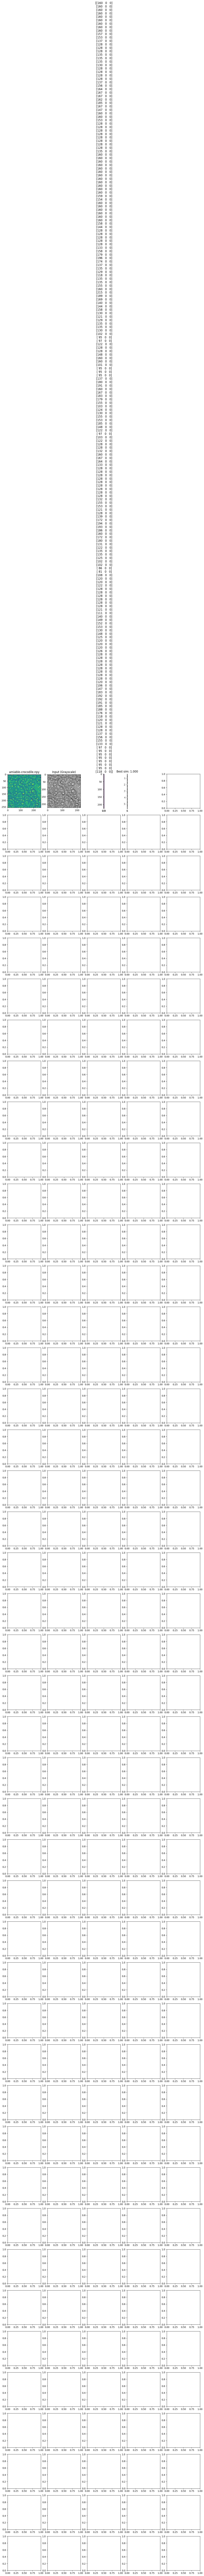

In [3]:
image_dir = os.path.join(db_path, 'input_images')
fig, ax = test_images([os.path.join(image_dir, x) for x in os.listdir(image_dir) if x.endswith('.npy')], "../tmp/test_fun.svg", db_path)

In [421]:
cv2.imread("../tmp/out_images_all/affable-shark.svg")

In [435]:
import xml.etree.ElementTree as ET

def concatenate_svgs(svg_filenames, output_filename):
    # Initialize the root SVG element
    root = ET.Element('svg')
    current_height = 0

    for filename in svg_filenames:
        tree = ET.parse(filename)
        svg = tree.getroot()

        # Adjust width and height of the root SVG element
        width = svg.attrib['width']
        root.attrib['width'] = width
        height = int(round(float(svg.attrib['height'].replace('pt', ''))))
        root.attrib['height'] = str(current_height + height)

        # Offset each SVG vertically
        for element in svg:
            for check_string in ['y', 'height']:
                if check_string in element.attrib:
                    element.attrib[check_string] = str(float(element.attrib[check_string]) + current_height)

            root.append(element)

        current_height += height
        print(current_height)

    # Write the final SVG to a file
    tree = ET.ElementTree(root)
    tree.write(output_filename)

# Example usage
svg_files = ['../tmp/out_images_all/affable-shark.svg', '../tmp/out_images_all/ambitious-ant.svg']  # Add your SVG filenames here
concatenate_svgs(svg_files, '../tmp/final_aggregated_image.svg')


215
430


In [428]:
int(round(float('214.977297')))

215

## Image display (using image_processor function)

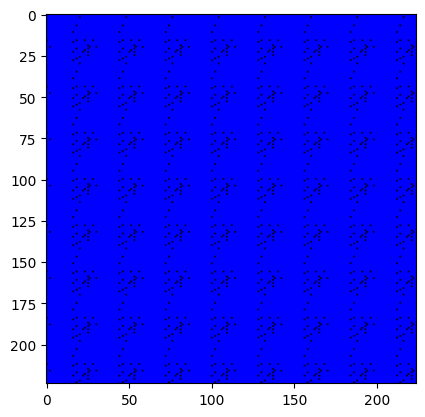

In [19]:
db_path = "../tmp/image_db/"
ip = ImageProcessor()
def show_image(image_processor : ImageProcessor, image_path : str, image_axes : str, grayscale : bool = False):
    input_image = ip.read_image(image_path)
    resized_image = ip.resize_image(input_image, image_axes, output_format = 'yxc', grayscale = grayscale)
    plt.imshow(resized_image[:,:,:])
# input_image = np.load("../tmp/image_db/input_images/polite-pig.npy")
# resized_image = ip.resize_image(input_image, current_format = "bcyx", output_format = "yxc", grayscale = False)
# plt.imshow(resized_image[:,:,:])
show_image(ip, *get_db_inputs(db_path, 'amiable-crocodile'), grayscale=False)

## Get DB inputs aux function

In [14]:
def get_db_inputs(db_path, model_name):
    image_dir = os.path.join(db_path, 'input_images')
    rdf_dir = os.path.join(db_path, 'rdf_sources')
    if np.any([~os.path.exists(x) for x in [image_dir, rdf_dir]]):
        ip = ImageProcessor()
        db = get_torch_db(db_path, ip)
    input_axes = get_axes(db_path, model_name)
    input_image_name = os.path.join(image_dir, f"{model_name}.npy")
    return(input_image_name, input_axes)

## Initialize the search db

In [122]:
ip = ImageProcessor()
db_path = "../tmp/image_db/"
_ = search_torch_db(ip, *get_db_inputs(db_path, 'affable-shark'), db_path = db_path)

Creating PyTorch image database from model zoo...


 17%|█▋        | 26/156 [02:08<10:43,  4.95s/it]


RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[1, 4, 224, 224] to have 3 channels, but got 4 channels instead